In [2]:
!pip install datasets
!pip install transformers[torch]
!pip install accelerate --upgrade
!pip install transformers==4.17

In [1]:
!pip install keras-core --upgrade
!pip install -q keras-nlp --upgrade

import os
os.environ['KERAS_BACKEND'] = 'tensorflow'

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras_core as keras
import keras_nlp
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("TensorFlow version:", tf.__version__)
print("KerasNLP version:", keras_nlp.__version__)

Using TensorFlow backend
TensorFlow version: 2.16.1
KerasNLP version: 0.12.1


In [4]:
test_path = "/content/disaster/test.csv"
train_path = "/content/disaster/train.csv"
df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)

print('Training Set Shape = {}'.format(df_train.shape))
print('Training Set Memory Usage = {:.2f} MB'.format(df_train.memory_usage().sum() / 1024**2))
print('Test Set Shape = {}'.format(df_test.shape))
print('Test Set Memory Usage = {:.2f} MB'.format(df_test.memory_usage().sum() / 1024**2))

Training Set Shape = (7613, 5)
Training Set Memory Usage = 0.29 MB
Test Set Shape = (3263, 4)
Test Set Memory Usage = 0.10 MB


In [5]:
print(df_train.head(2))
print(df_test.head(2))

   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   

   target  
0       1  
1       1  
   id keyword location                                               text
0   0     NaN      NaN                 Just happened a terrible car crash
1   2     NaN      NaN  Heard about #earthquake is different cities, s...


## Explore the dataset

In [6]:
'''
describe() is useful
'''
df_train["length"] = df_train["text"].apply(lambda x : len(x))
df_test["length"] = df_test["text"].apply(lambda x : len(x))

print("Train Length Stat")
print(df_train["length"].describe())

print("Test Length Stat")
print(df_test["length"].describe())

Train Length Stat
count    7613.000000
mean      101.037436
std        33.781325
min         7.000000
25%        78.000000
50%       107.000000
75%       133.000000
max       157.000000
Name: length, dtype: float64
Test Length Stat
count    3263.000000
mean      102.108183
std        33.972158
min         5.000000
25%        78.000000
50%       109.000000
75%       134.000000
max       151.000000
Name: length, dtype: float64


In [7]:
print(df_train.keyword.nunique())
print(df_test.keyword.nunique())

221
221


In [8]:
print(df_train.keyword.value_counts().iloc[:10])
print(df_test.keyword.value_counts().iloc[:10])

keyword
fatalities     45
deluge         42
armageddon     42
sinking        41
damage         41
harm           41
body%20bags    41
outbreak       40
evacuate       40
fear           40
Name: count, dtype: int64
keyword
deluged               23
demolished            22
rubble                22
first%20responders    21
seismic               21
obliteration          21
sirens                21
annihilation          21
snowstorm             21
avalanche             20
Name: count, dtype: int64


## Preprocess the data

### Cleaned data

In [9]:
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def clean_text(text):

    text = text.lower()
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'[^a-z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()

    return text

df_train['text'] = df_train['text'].apply(clean_text)
df_test['text'] = df_test['text'].apply(clean_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Naive Bayes

In [10]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn import metrics
import nltk
nltk.download('stopwords')
nltk.download('punkt')

X = df_train["text"]
y = df_train["target"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.65, random_state=42)

X_test = df_test["text"]


pipe = Pipeline([('bow', CountVectorizer(stop_words='english', tokenizer=word_tokenize)),
                 ('tfid', TfidfTransformer()),
                 ('model', MultinomialNB())])

pipe.fit(X_train, y_train)

y_pred_class = pipe.predict(X_val)

print(metrics.accuracy_score(y_val, y_pred_class))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


0.7936956961002223


### DistilBERT

In [11]:
BATCH_SIZE = 32 #32
NUM_TRAINING_EXAMPLES = df_train.shape[0]
TRAIN_SPLIT = 0.8
VAL_SPLIT = 0.2
STEPS_PER_EPOCH = int(NUM_TRAINING_EXAMPLES)*TRAIN_SPLIT // BATCH_SIZE

EPOCHS = 2
AUTO = tf.data.experimental.AUTOTUNE

In [12]:
from sklearn.model_selection import train_test_split

X = df_train["text"]
y = df_train["target"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=VAL_SPLIT, random_state=42)

X_test = df_test["text"]

## Load a DistilBERT model from Keras NLP

In [13]:
# Load a DistilBERT model.
preset= "distil_bert_base_en_uncased"

# Use a shorter sequence length.
preprocessor = keras_nlp.models.DistilBertPreprocessor.from_preset(preset,
                                                                   sequence_length=160,
                                                                   name="preprocessor_4_tweets"
                                                                  )

# Pretrained classifier.
classifier = keras_nlp.models.DistilBertClassifier.from_preset(preset,
                                                               preprocessor = preprocessor,
                                                               num_classes=2)

classifier.summary()

Preprocessor: "preprocessor_4_tweets"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ distil_bert_tokenizer (DistilBertTokenizer)        │                                              30,522 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "distil_bert_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ distil_bert_backbone          │ (None, None, 768)         │      66,362,880 │ padding_mask[0][0],        │
│ (DistilBertBackbone)          │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ get_item (GetItem)            │ (None, 768)               │               0 │ distil_bert_backbone[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pooled_dense (Dense)          │ (None, 768)               │         590,592 │ get_item[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ output_dropout (Dropout)      │ (None, 768)               │               0 │ pooled_dense[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ logits (Dense)                │ (None, 2)                 │           1,538 │ output_dropout[0][0]       │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 66,955,010 (255.41 MB)

 Trainable params: 66,955,010 (255.41 MB)

 Non-trainable params: 0 (0.00 B)

## fine-tuning BERT

In [14]:
def displayConfusionMatrix(y_true, y_pred, dataset):
    disp = ConfusionMatrixDisplay.from_predictions(
        y_true,
        np.argmax(y_pred, axis=1),
        display_labels=["Not Disaster","Disaster"],
        cmap=plt.cm.Blues
    )

    tn, fp, fn, tp = confusion_matrix(y_true, np.argmax(y_pred, axis=1)).ravel()
    f1_score = tp / (tp+((fn+fp)/2))

    disp.ax_.set_title("Confusion Matrix on " + dataset + " Dataset -- F1 Score: " + str(f1_score.round(2)))

In [15]:
# Compile

classifier.compile(
    loss= keras.losses.SparseCategoricalCrossentropy(from_logits=True), #'binary_crossentropy',
    optimizer= tf.keras.optimizers.Adam(1e-5),
    metrics= ["accuracy"]
)

# Fit
history = classifier.fit(x=X_train,
                         y=y_train,
                         batch_size=BATCH_SIZE,
                         epochs=EPOCHS,
                         validation_data=(X_val, y_val)
                        )

Epoch 1/2
191/191 ━━━━━━━━━━━━━━━━━━━━ 257s 851ms/step - accuracy: 0.7426 - loss: 0.5618 - val_accuracy: 0.8339 - val_loss: 0.3993
Epoch 2/2
191/191 ━━━━━━━━━━━━━━━━━━━━ 107s 559ms/step - accuracy: 0.8388 - loss: 0.3796 - val_accuracy: 0.8411 - val_loss: 0.3957


191/191 ━━━━━━━━━━━━━━━━━━━━ 32s 156ms/step


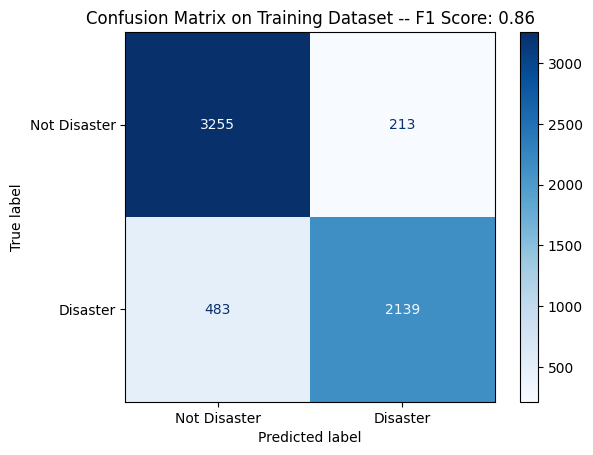

In [16]:
y_pred_train = classifier.predict(X_train)

displayConfusionMatrix(y_train, y_pred_train, "Training")

48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 157ms/step


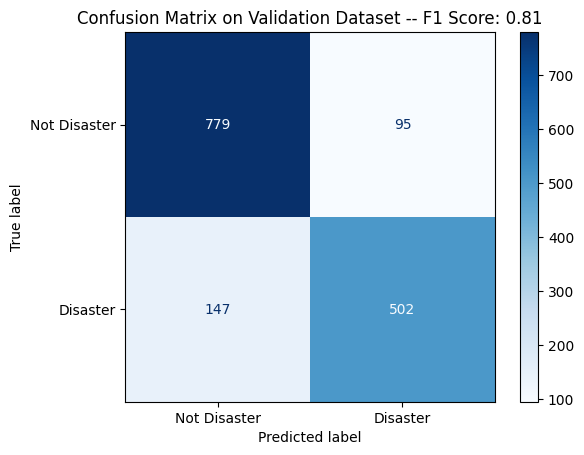

In [17]:
y_pred_val = classifier.predict(X_val)

displayConfusionMatrix(y_val, y_pred_val, "Validation")

## Generate the submission file

In [18]:
# sample_submission = pd.read_csv("/content/submission.csv")
# sample_submission.head()
# sample_submission["target"] = np.argmax(classifier.predict(X_test), axis=1)
# print(sample_submission.describe())
# sample_submission.to_csv("/content/submission.csv", index=False)

## emotion

In [19]:
import pandas as pd

anger_train = pd.read_csv("/content/emotion/train/anger-ratings-0to1.train.txt",
                         sep="\t", header=None,names=["id", "text", "emotion", "intensity"])
sadness_train = pd.read_csv("/content/emotion/train/sadness-ratings-0to1.train.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])
fear_train = pd.read_csv("/content/emotion/train/fear-ratings-0to1.train.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])
joy_train = pd.read_csv("/content/emotion/train/joy-ratings-0to1.train.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])

train_df = pd.concat([anger_train, fear_train, joy_train, sadness_train], ignore_index=True)
display(train_df)


,id,text,emotion,intensity
0,10000,How the fu*k! Who the heck! moved my fridge!.....,anger,0.938
1,10001,So my Indian Uber driver just called someone t...,anger,0.896
2,10002,@DPD_UK I asked for my parcel to be delivered ...,anger,0.896
3,10003,so ef whichever butt wipe pulled the fire alar...,anger,0.896
4,10004,Don't join @BTCare they put the phone down on ...,anger,0.896
...,...,...,...,...
3608,40781,@VivienLloyd Thank you so much! Just home - st...,sadness,0.104
3609,40782,Just put the winter duvet on ☃️❄️🌬☔️,sadness,0.104
3610,40783,@SilkInSide @TommyJoeRatliff that's so pretty!...,sadness,0.088
3611,40784,@BluesfestByron second artist announcement loo...,sadness,0.083


In [20]:
anger_test = pd.read_csv("/content/emotion/dev/anger-ratings-0to1.dev.gold.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])
sadness_test = pd.read_csv("/content/emotion/dev/sadness-ratings-0to1.dev.gold.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])
fear_test = pd.read_csv("/content/emotion/dev/fear-ratings-0to1.dev.gold.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])
joy_test = pd.read_csv("/content/emotion/dev/joy-ratings-0to1.dev.gold.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])

test_df = pd.concat([anger_test, fear_test, joy_test, sadness_test], ignore_index=True)
display(test_df)

,id,text,emotion,intensity
0,10857,@ZubairSabirPTI pls dont insult the word 'Molna',anger,0.479
1,10858,@ArcticFantasy I would have almost took offens...,anger,0.458
2,10859,@IllinoisLoyalty that Rutgers game was an abom...,anger,0.562
3,10860,@CozanGaming that's what lisa asked before she...,anger,0.500
4,10861,Sometimes I get mad over something so minuscul...,anger,0.708
...,...,...,...,...
342,40855,Common app just randomly logged me out as I wa...,sadness,0.833
343,40856,"I'd rather laugh with the rarest genius, in be...",sadness,0.688
344,40857,If you #invest in my new #film I will stop ask...,sadness,0.458
345,40858,"Just watched Django Unchained, Other people ma...",sadness,0.333


In [21]:
train_df['text'] = train_df['text'].apply(clean_text)
test_df['text'] = test_df['text'].apply(clean_text)

In [22]:
print(train_df['intensity'].describe())
print(test_df['intensity'].describe())

count    3613.000000
mean        0.495199
std         0.190368
min         0.019000
25%         0.354000
50%         0.479000
75%         0.625000
max         0.980000
Name: intensity, dtype: float64
count    347.000000
mean       0.485141
std        0.185427
min        0.038000
25%        0.354000
50%        0.460000
75%        0.625000
max        0.936000
Name: intensity, dtype: float64


In [23]:
# train_df = train_df[train_df['intensity'] > 0.4]
# test_df = test_df[test_df['intensity'] > 0.4]

# print(train_df['intensity'].describe())
# print(test_df['intensity'].describe())

In [24]:
train_df = train_df.drop(['intensity','id'], axis=1)
test_df = test_df.drop(['intensity','id'], axis=1)

test_df = test_df.rename(columns={'emotion': 'label'})
train_df = train_df.rename(columns={'emotion': 'label'})
train_df.head(2)

,text,label
0,how the fuk who the heck moved my fridge shoul...,anger
1,so my indian uber driver just called someone t...,anger


In [25]:
df_train = df_train.drop(['id','keyword','location','target'], axis=1)
df_test = df_test.drop(['id','keyword','location'], axis=1)

In [26]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
label_encoder.fit(train_df['label'])

def label_encode(le, labels):
    enc = le.transform(labels)
    return enc

y_train = label_encode(label_encoder, train_df['label'])
y_test = label_encode(label_encoder, test_df['label'])

train_df['label'] = y_train
test_df['label'] = y_test

train_df.head(2)

,text,label
0,how the fuk who the heck moved my fridge shoul...,0
1,so my indian uber driver just called someone t...,0


In [27]:
from transformers import AutoTokenizer
import datasets
from datasets import Dataset

model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

emotions = datasets.DatasetDict({"train":Dataset.from_dict(train_df),"test":Dataset.from_dict(test_df), "df_train":Dataset.from_dict(df_train), "df_test":Dataset.from_dict(df_test)})

emotions.reset_format()
emotions_encoded = emotions.map(tokenize, batched=True)


Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Map:   0%|          | 0/3613 [00:00<?, ? examples/s]

Map:   0%|          | 0/347 [00:00<?, ? examples/s]

Map:   0%|          | 0/7613 [00:00<?, ? examples/s]

Map:   0%|          | 0/3263 [00:00<?, ? examples/s]

In [28]:
from transformers import AutoModelForSequenceClassification
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_labels = 4
id2label = {
    "0": "anger",
    "1": "fear",
    "2": "joy",
    "3": "sadness"
}
label2id = {
    "anger": 0,
    "fear": 1,
    "joy": 2,
    "sadness": 3
}

model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels, id2label=id2label, label2id=label2id).to(device)

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.weight', 'classifi

In [29]:
from transformers import Trainer, TrainingArguments

batch_size = 32
logging_steps = len(emotions_encoded) // batch_size
model_name = f"{model_ckpt}-finetuned-emotion"

In [30]:

training_args = TrainingArguments(

    output_dir=model_name,
    num_train_epochs=3,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    disable_tqdm=False,
    logging_steps=max(1, logging_steps),
    push_to_hub=False,  # Set to False to disable pushing to the Hub

)

In [31]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [32]:
from huggingface_hub import notebook_login
notebook_login()

In [33]:
trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=emotions_encoded['train'],
    eval_dataset=emotions_encoded['test'],
    tokenizer=tokenizer
)

In [34]:
trainer.train()

The following columns in the training set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 3613
  Num Epochs = 3
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 339


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.958200,0.920061,0.674352,0.669933
2,0.666400,0.567781,0.795389,0.795216
3,0.541100,0.526918,0.812680,0.813081


The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 347
  Batch size = 32
The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 347
  Batch size = 32
The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples =

TrainOutput(global_step=339, training_loss=0.7891998275630945, metrics={'train_runtime': 47.7979, 'train_samples_per_second': 226.767, 'train_steps_per_second': 7.092, 'total_flos': 117785829118608.0, 'train_loss': 0.7891998275630945, 'epoch': 3.0})

In [38]:
train_path = "/content/disaster/train.csv"
df_train_all = pd.read_csv(train_path)
# print(df_train_all['target'])

In [37]:
preds_output = trainer.predict(emotions_encoded["df_train"])

The following columns in the test set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: length, text. If length, text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 7613
  Batch size = 32


In [39]:
# transformers.trainer_utils.PredictionOutput
preds_output

PredictionOutput(predictions=array([[ 0.08981335,  2.0485468 , -1.6258723 ,  0.06454477],
       [-0.1317514 ,  2.1933858 , -1.4773598 , -0.16458754],
       [-0.87901884,  2.6114519 , -1.2212441 ,  0.02065803],
       ...,
       [ 0.18394639,  1.335853  , -0.9460492 , -0.25544715],
       [-0.83887476,  2.412122  , -1.22767   ,  0.33520657],
       [-0.37694556,  2.5161953 , -1.4158568 , -0.14407393]],
      dtype=float32), label_ids=None, metrics={'test_runtime': 9.2917, 'test_samples_per_second': 819.332, 'test_steps_per_second': 25.614})

In [40]:
import numpy as np
res = np.argmax(np.array(preds_output[0]),axis=1)

In [43]:
print("anger", len(np.where(res==0)[0]))
print("fear", len(np.where(res==1)[0]))
print("joy", len(np.where(res==2)[0]))
print("sadness", len(np.where(res==3)[0]))

anger 1182
fear 5224
joy 304
sadness 903


In [47]:
AND = set(np.where(res==2)[0]).intersection(np.where(df_train_all["target"]==1)[0])
len(AND)

39

In [51]:
print("TRUE disaster with JOY case")
for i in AND:
 print(df_train_all["text"][i])

TRUE disaster with JOY case
Happy boy to mass murderer http://t.co/xPddWH5teM
Watch our video of Wendell Berry speaking about the BP oil spill in the Gulf of Mexico.

ItÛªs the birthday... http://t.co/tN1aX1xMBB
@Nervana_1 
As per previous behaviour JAN/AQ would deal with the kidnapped hostages not particularly pleasantly if Div 30 fought JAN/AQ.
Newlyweds feed thousands of Syrian refugees instead of hosting a banquet wedding dinner -  http://t.co/XZV0lT9ZZk via @smh
'I came to kill Indians...for FUN': Video of smirking and remorseless Pakistani killer shows him boasting. http://t.co/FPjLwOXKlg
@stallion150 @kbeastx they totally demolished genisys which was a beautiful film and almost 90% of the people agreed
TodayÛªs storm will pass; let tomorrowÛªs light greet you with a kiss. Bask in this loving warmth; let your soul return to bliss.
Heavy rain gusty winds and vivid lightning moving east through the Triad now. http://t.co/JMu5uyamdu
@Raishimi33 :) well I think that sounds like a 